# Strongly Connected Components
The _Strongly Connected Components_ (SCC) algorithm finds sets of connected nodes in a directed graph where each node is reachable in both directions from any other node in the same set.
It is often used early in a graph analysis process to help us get an idea of how our graph is structured.

First we'll import the Neo4j driver and Pandas libraries:


In [1]:
from neo4j import GraphDatabase
import pandas as pd
import os

Next let's create an instance of the Neo4j driver which we'll use to execute our queries.


In [2]:
host = os.environ.get("NEO4J_HOST", "bolt://localhost") 
user = os.environ.get("NEO4J_USER", "neo4j")
password = os.environ.get("NEO4J_PASSWORD", "neo")
driver = GraphDatabase.driver(host, auth=(user, password))

Now let's create a sample graph that we'll run the algorithm against.


In [3]:
create_graph_query = '''
MERGE (nAlice:User {id:'Alice'})
MERGE (nBridget:User {id:'Bridget'})
MERGE (nCharles:User {id:'Charles'})
MERGE (nDoug:User {id:'Doug'})
MERGE (nMark:User {id:'Mark'})
MERGE (nMichael:User {id:'Michael'})

MERGE (nAlice)-[:FOLLOW]->(nBridget)
MERGE (nAlice)-[:FOLLOW]->(nCharles)
MERGE (nMark)-[:FOLLOW]->(nDoug)
MERGE (nMark)-[:FOLLOW]->(nMichael)
MERGE (nBridget)-[:FOLLOW]->(nMichael)
MERGE (nDoug)-[:FOLLOW]->(nMark)
MERGE (nMichael)-[:FOLLOW]->(nAlice)
MERGE (nAlice)-[:FOLLOW]->(nMichael)
MERGE (nBridget)-[:FOLLOW]->(nAlice)
MERGE (nMichael)-[:FOLLOW]->(nBridget);
'''

with driver.session() as session:
    result = session.write_transaction(lambda tx: tx.run(create_graph_query))
    print("Stats: " + str(result.consume().metadata.get("stats", {})))

Stats: {'labels-added': 6, 'relationships-created': 10, 'nodes-created': 6, 'properties-set': 6}


Finally we can run the algorithm by executing the following query:


In [4]:
streaming_query = """
CALL gds.alpha.scc.stream({
  nodeProjection:'User',
  relationshipProjection:'FOLLOW'})
YIELD nodeId, componentId
RETURN gds.util.asNode(nodeId).id AS name, componentId
"""

with driver.session() as session:
    result = session.run(streaming_query)        
    df = pd.DataFrame([dict(r) for r in result])

df

,name,componentId
0,Charles,0
1,Doug,1
2,Mark,1
3,Michael,3
4,Alice,3
5,Bridget,3


We have 3 strongly connected components in our sample graph.
The first and biggest component has members Alice, Bridget, and Michael, while the second component has Doug and Mark.
Charles ends up in his own component becuase there isn't an outgoing relationship from that node to any of the others.

We can also call a version of the algorithm that will store the result as a property on a
node. This is useful if we want to run future queries that use the result.

In [5]:
write_query = """
CALL gds.alpha.scc.write({
  nodeProjection:'User',
  relationshipProjection:'FOLLOW',
  writeProperty:'partition'})
YIELD createMillis, computeMillis, writeMillis, setCount, maxSetSize, minSetSize;
"""

with driver.session() as session:
    session.write_transaction(lambda tx: tx.run(write_query))

## Graph Visualisation

Sometimes a picture can tell more than a table of results and this is often the case with graph algorithms. 
Let's see how to create a graph visualization using neovis.js.

First we'll create a div into which we will generate the visualisation.

In [30]:
%%html
<style type="text/css">                
.output_wrapper, .output {
    height:auto !important;
    max-height:600px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}

#viz {
    width: 300px;
    height: 350px;
    font: 22pt arial;
}
</style>  
<div id="viz"></div>

Next we need to define the query that the visualization will be generated from, along with config 
that describes which properties will be used for node size, node colour, and relationship width. 

We'll then define a JavaScript variable that contains all our parameters.

In [31]:
from IPython.core.display import Javascript
import json
from scripts.algo import viz_config, render_image

config = viz_config("Strongly Connected Components")
query = config["query"]
labels_json = config["labels_json"]
relationships_json = config["relationships_json"]

json_graph = {
    "query": query,
    "labels": labels_json,
    "relationships": relationships_json,
    "host": host,
    "user": user,
    "password": password
}

Javascript("""window.jsonGraph={};""".format(json.dumps(json_graph)))

<IPython.core.display.Javascript object>

Now we're ready to call neovis.js and generate our graph visualisation. 
The following code will create an interactive graph into the div defined above.
It will also extract an image representation of the graph and display that in the cell below.

In [32]:
%%javascript
var output_area = this;
requirejs(['neovis.js'], function(NeoVis){    
    var config = {
      container_id: "viz",
      server_url: window.jsonGraph.host,
      server_user: window.jsonGraph.user,
      server_password: window.jsonGraph.password,
      labels: window.jsonGraph.labels,
      relationships: window.jsonGraph.relationships,
      initial_cypher: window.jsonGraph.query
    };
        
    let viz = new NeoVis.default(config);
    viz.render();
    
    viz.onVisualizationRendered(function(ctx) {
      let imageSrc = ctx.canvas.toDataURL();
      let kernel = IPython.notebook.kernel;
      let command = "image_src = '" + imageSrc + "'";
      kernel.execute(command);
      
      var cell_element = output_area.element.parents('.cell');
      var cell_idx = Jupyter.notebook.get_cell_elements().index(cell_element);
      var cell = Jupyter.notebook.get_cell(cell_idx+1);
      cell.set_text("render_image(image_src)")
      cell.execute();
    });
});

<IPython.core.display.Javascript object>


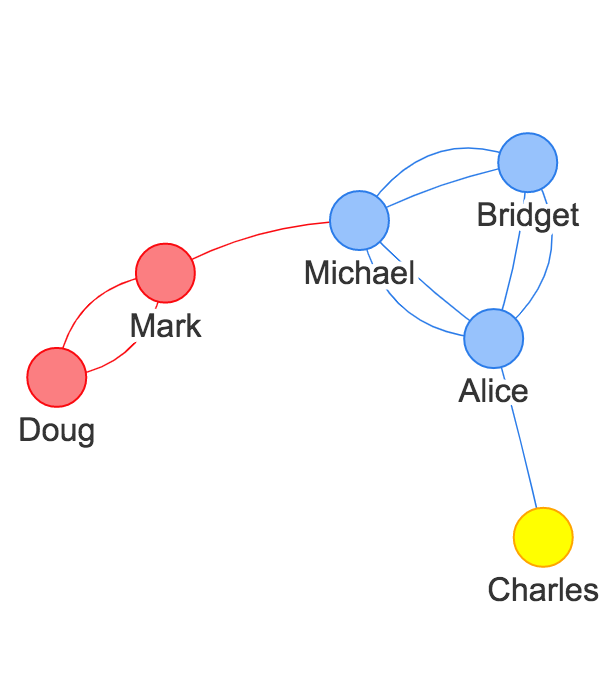

In [35]:
render_image(image_src)